+ look for shortest and longest posts 
+ count vectorize 
+ find most common words in both 

+ combine into one dataframe 
+ map to 0 1 
+ value counts --> null model 


In [92]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from nltk import FreqDist, pos_tag
from nltk.tokenize import word_tokenize
from collections import Counter

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


## EDA 

In [93]:
# reading in clean dataframes 

def load_clean_data(filename):
    full_file = '../datasets/' + filename + '.csv'
    df = pd.read_csv(full_file)
    return df

In [94]:
vikings = load_clean_data('vikings_clean')

In [95]:
vikings.head()

,label,merged,tokens
0,vikings,"want to hate rodgers,but be just seems like ...","['want', 'to', 'hate', 'rodgers', 'but', 'be',..."
1,vikings,"alright im bored, what are some good games to ...","['alright', 'im', 'bored', 'what', 'are', 'som..."
2,vikings,"cb update going in to week 17, gladney ranks ...","['cb', 'update', 'going', 'in', 'to', 'week', ..."
3,vikings,"cb update going in to week 17, gladney ranks ...","['cb', 'update', 'going', 'in', 'to', 'week', ..."
4,vikings,the over 30 club which players will be 30 in ...,"['the', 'over', '30', 'club', 'which', 'player..."


In [96]:
vikings.shape

(200, 3)

In [97]:
johnprine = load_clean_data('prine_clean')

In [98]:
johnprine.head()

,label,merged,tokens
0,prine,bill murray on john prine,"['bill', 'murray', 'on', 'john', 'prine']"
1,prine,it's my cake day listen to john prine for me ...,"['it', 's', 'my', 'cake', 'day', 'listen', 'to..."
2,prine,here's a pic of my son next to a pic of my unc...,"['here', 's', 'a', 'pic', 'of', 'my', 'son', '..."
3,prine,"1110 s 1st ave maywood, il 60153","['1110', 's', '1st', 'ave', 'maywood', 'il', '..."
4,prine,got this original pressing of bruised orange i...,"['got', 'this', 'original', 'pressing', 'of', ..."


In [99]:
johnprine.shape

(200, 3)

#### Inspecting common words and posts lengths in separate dataframes

In [100]:
def vectorize_and_plot(df, text_field):
    cvec = CountVectorizer(stop_words='english')
    col = df[text_field]
    cvec.fit(col)
    col = cvec.transform(col)
    plot_df = pd.DataFrame(col.todense(),
                          columns=cvec.get_feature_names())
    plot_df.sum().sort_values(ascending=False).head(10).plot(kind='barh');

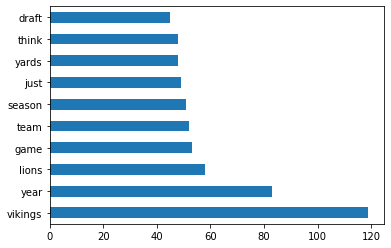

In [101]:
vectorize_and_plot(vikings, 'merged')

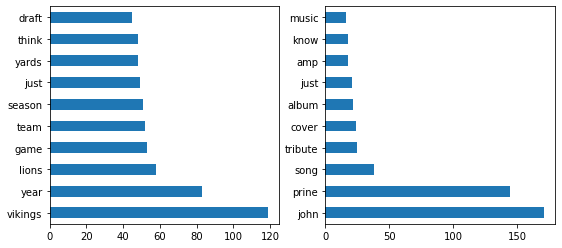

In [102]:
plt.figure(figsize=(14, 4))
plt.subplot(131)
vectorize_and_plot(vikings, 'merged')
plt.subplot(132)
vectorize_and_plot(johnprine, 'merged')

In [147]:
# code inspired by Emmanuel 
# line of code for extracting name from DataFrame to print it and use it as plot title is from this stack overflow page: 
# https://stackoverflow.com/questions/54137694/how-to-print-dataframe-name-in-title-of-a-plot

def post_length_distribution(df):
    
    #getting size of vocabulary 
    all_words = [word for tokens in df['tokens'] for word in tokens]    # getting all the words in the posts
    post_lengths = [len(tokens) for tokens in df['tokens']]    # getting length of the all the posts
    vocab = sorted(list(set(all_words)))    # getting the list of unique words in the corpus composed of the subreddit posts
    
    df_name = [x for x in globals() if globals()[x] is df][0]
    print(f'Post Lengths for {df_name.capitalize()} dataset:')
    
    print(f'{len(all_words)} words total, with a vocabulary size of {len(vocab)}')
    print(f'Max post length is {max(post_lengths)} words')
    print(f'Average post length is {np.mean(post_lengths).round(2)} words') 
    
    # plotting distribution 
    fig = plt.figure(figsize=(6,6))
    plt.xlabel('Post Length')
    plt.ylabel('Number of Posts')
    plt.title(df_name.capitalize())
    plt.hist(post_lengths, bins=100, range=[0, 1500])
    plt.show()

Post Lengths for Vikings dataset:
83147 words total, with a vocabulary size of 42
Max post length is 6307 words
Average post length is 454.36 words


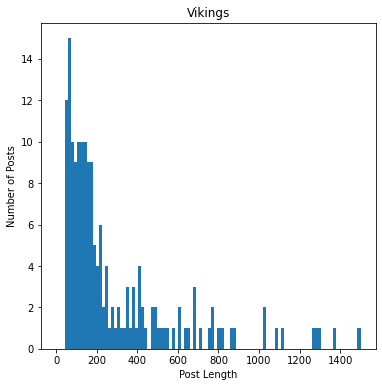

In [148]:
post_length_distribution(vikings)

Post Lengths for Johnprine dataset:
46476 words total, with a vocabulary size of 42
Max post length is 4762 words
Average post length is 232.38 words


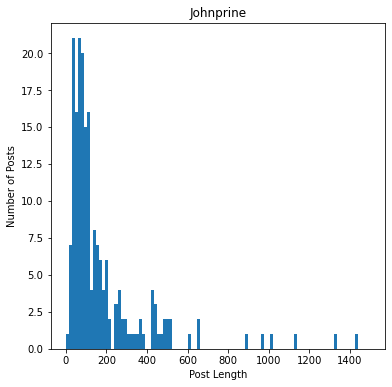

In [150]:
post_length_distribution(johnprine)

In [47]:
# def remove_large_small(df, text_field):
#     post_lengths = [len(tokens) for tokens in df['tokens']] # getting length of the all the posts
#     for val in df[text_field]:
#         if val > 

#### Removing long and short posts 

Below function will remove the longest and shortest posts from a dataframe since having a disproportionate number of words come from the same person/post might add unnecessary redundancy that does not reflect the entire corpus. 

**Longest posts:** 

`df['tokens'].map(lambda x: len(x)).nlargest(10)` 

**Shortest posts:**

`df['tokens'].map(lambda x: len(x)).nsmallest(20)`

    or:
   
`df[df['tokens'].str.split().str.len() < 5`


_Inspect results from longest and shortest posts functions above._ 

+ If one or more posts appears to be longer by multiple times or orders of magnitude, remove the row containing that post using the index numbers displayed.  

```
df.drop([idx], inplace=True)
```


+ Remove very short posts as follows: 

```
df = df[df['tokens'].str.split().str.len() > 5]
```


+ Rerun `post_length_distribution` function following this process to see how distribution has changed.  

In [140]:
vikings['tokens'].map(lambda x: len(x)).nlargest(10)

111    25035
132    11529
197     6307
148     5724
74      3250
11      2868
18      2418
23      2246
72      2173
55      1994
Name: tokens, dtype: int64

In [141]:
vikings.drop([111, 132], inplace=True)

In [142]:
vikings[vikings['tokens'].str.split().str.len() < 5]

,label,merged,tokens
48,vikings,i m conflicted,"['i', 'm', 'conflicted']"
58,vikings,some awesome football helmets,"['some', 'awesome', 'football', 'helmets']"
67,vikings,maybe next year guys,"['maybe', 'next', 'year', 'guys']"
79,vikings,courtney cronin on twitter,"['courtney', 'cronin', 'on', 'twitter']"
92,vikings,plz,['plz']
117,vikings,bring back 96 questions,"['bring', 'back', '96', 'questions']"
143,vikings,viking wall shelf,"['viking', 'wall', 'shelf']"
147,vikings,meanwhile in ftp land,"['meanwhile', 'in', 'ftp', 'land']"
165,vikings,laquon treadwell td!! removed,"['laquon', 'treadwell', 'td', 'removed']"
193,vikings,jjets on twitter,"['jjets', 'on', 'twitter']"


In [143]:
vikings = vikings[vikings['tokens'].str.split().str.len() > 5]

In [144]:
vikings.shape

(183, 3)

Post Lengths for Vikings dataset:
83147 words total, with a vocabulary size of 42
Max post length is 6307 words
Average post length is 454.36 words


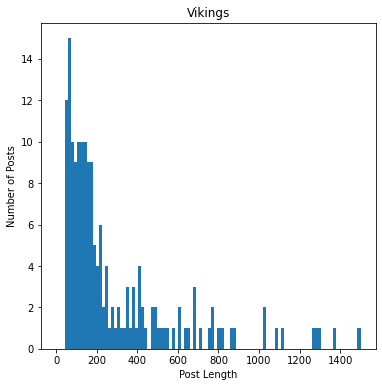

In [145]:
post_length_distribution(vikings)

In [138]:
johnprine['tokens'].map(lambda x: len(x)).nlargest(10)

32     4762
44     2530
118    2312
82     1632
76     1430
25     1327
74     1126
38     1015
35      971
120     885
Name: tokens, dtype: int64

In [139]:
johnprine['tokens'].map(lambda x: len(x)).mean()

232.38

In [152]:
johnprine['merged'].iloc[32]

"revised poem post with a letter hello in there,\n\nas the year drags on, i can t help but think about the absence created by the loss of john prine  thinking about his life   what you could know of it from his music and as an appreciator of his art   i can t help but shed a tear thinking about his first few and very last song(s)  imaging the deep ocean of experiences that spanned between it with all its shifting tides brought on by years of living \n\nwordsmiths, i believe, are few and far between nowadays, not to say that there aren t any at all  but i have always found comfort from artists of the past   waylon  amp  willie, townes van zandt, tom t  hall, merle haggard, bruce springsteen, bobbie gentry, etc, etc     the likes of which have shaped the silent rebel i have come to be  unwavering and uncompromising in my journey to deeply appreciate and engage my life as one worth living \n\namong all my heroes dead and alive, those who have caught my ear in moments of depression and rep

_Deciding for now not to drop any of the long posts from the John Prine dataframe because there is not 3 or fewer that are far longer than all the rest. Might drop them in the future if it seems relevant._

In [154]:
# shortest john prine posts

johnprine[johnprine['tokens'].str.split().str.len() < 3]

,label,merged,tokens
10,prine,silver bells,"['silver', 'bells']"
21,prine,thanks john!,"['thanks', 'john']"
40,prine,the boogeyman,"['the', 'boogeyman']"
55,prine,john prine,"['john', 'prine']"
62,prine,finally delivered!,"['finally', 'delivered']"
110,prine,love,['love']


In [155]:
johnprine = johnprine[johnprine['tokens'].str.split().str.len() > 2]

## Model Prep 

#### Combining DataFrames 

don't forget null model! 

In [157]:
# def model_df(subreddit_1, subreddit_2):
    
#     model_df = pd.concat([subreddit_1, subreddit_2])
    
#     # resetting index
#     model_df.reset_index(drop=True, inplace=True)
    
#     model_df['label'] = model_df['label'].map({subreddit_1: 0, subreddit_2: 1})
    
#     # save concatenated datadframe to csv file 
#     filename = 'subreddit_1' + '_' + 'subredit_2' + '.csv'
#     model_df.to_csv('../datasets/' + filename, index=False)
    
#     return model_df 

## ^^^ This doesn't work beause dataframe can't be hashed ala the map function 

**Steps to build dataframe and prep for modeling:**

_Naming convention for new combined dataframe will be `subreddit1_subreddit2`, but is referenced in these instructions as `df`._

1. Combine separate datasets into on dataframe using this line of code: 

```python
df = pd.concat([subreddit_1, subreddit_2])
```

2. Reset index: 

```python
df.reset_index(drop=True, inplace=True)
```

3. Changes labels to binary numeric labels:

```python
df['label'] = df['label'].map({subreddit1: 0, subreddit2: 1})
```

3. Save concatenated datadframe to csv file:

```python 
filename = 'subreddit_1' + '_' + 'subredit_2' + '.csv'
df.to_csv('../datasets/' + filename, index=False)
```

In [158]:
# concantenating John Prine and Minnesota Vikings dataframes 

prine_vikings = pd.concat([johnprine, vikings])

prine_vikings.reset_index(drop=True, inplace=True) 

prine_vikings['label']  = prine_vikings['label'].map({'prine': 0, 'vikings': 1})

In [159]:
prine_vikings.head()

,label,merged,tokens
0,0,bill murray on john prine,"['bill', 'murray', 'on', 'john', 'prine']"
1,0,it's my cake day listen to john prine for me ...,"['it', 's', 'my', 'cake', 'day', 'listen', 'to..."
2,0,here's a pic of my son next to a pic of my unc...,"['here', 's', 'a', 'pic', 'of', 'my', 'son', '..."
3,0,"1110 s 1st ave maywood, il 60153","['1110', 's', '1st', 'ave', 'maywood', 'il', '..."
4,0,got this original pressing of bruised orange i...,"['got', 'this', 'original', 'pressing', 'of', ..."


In [160]:
prine_vikings.tail()

,label,merged,tokens
372,1,people blaming the defense without multiple st...,"['people', 'blaming', 'the', 'defense', 'witho..."
373,1,some of my thoughts whenever watching a gam...,"['some', 'of', 'my', 'thoughts', 'whenever', '..."
374,1,don't commit suicide (personal gameday post f...,"['don', 't', 'commit', 'suicide', 'personal', ..."
375,1,this man will be looking for head coaching pos...,"['this', 'man', 'will', 'be', 'looking', 'for'..."
376,1,can anyone id the player signature shown?,"['can', 'anyone', 'id', 'the', 'player', 'sign..."


In [161]:
prine_vikings.to_csv('../datasets/prine_vikings.csv', index=False)

In [162]:
prine_vikings.shape

(377, 3)